<a href="https://colab.research.google.com/github/IsinghGitHub/CellStrat/blob/master/TC_MODEL_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing input dataset from Drive and unzipping it.
import zipfile
path = '/content/drive/MyDrive/toilet-classifier.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [3]:
#Installing required packages

!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 48.8 MB/s eta 0:00:00


In [4]:
#Installing required packages

!pip install albumentations


In [5]:
#Installing required packages

!pip install pytorch_lightning

In [6]:
!pip install torchinfo

In [7]:
import os
# The images are in a folder named 'input/natural-images/natural_images'
training_folder_name = '/content/toilet-classifier/data/toilet-classifier/training'

# All images are 128x128 pixels
img_size = (128,128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['.DS_Store', '275517', '275518', '275519', '275520', '275521', '289300', '296029', '296031', '300466', '300540', '300541', '301500', '301501', '301502', '303038', '304357', '304374', '307218', '307219', '307267', '307291', '307372', '307379', '308443', '308462', '313203', '314334', '314335', '314337', '314338', '314339', '314341', '314343', '314688', '314689', '314690', '314691', '314692', '314693', '314694', '314695']


In [8]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.optim import Adam
print("Libraries imported - ready to use PyTorch", torch.__version__)
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable

Libraries imported - ready to use PyTorch 2.1.0+cu118


In [9]:
from PIL import Image

# function to resize image
def resize_image(src_image, size=(128,128), bg_color="white"):
    from PIL import Image, ImageOps

    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)

    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)

    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))

    # return the resized image
    return new_image

In [10]:
#Importing required libraries

import albumentations as A
import pytorch_lightning as L
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image

from torchvision import transforms as tv_transforms
from torch.utils.data import DataLoader
import yaml
import numpy as np

size = (224, 224)


class ToiletDataModule(L.LightningDataModule):
    def __init__(
        self,
        datasets: str,
        transforms: list = None,
        batch_size: int = 32,
        data_dir: str = "/content/toilet-classifier/data",
        num_workers: int = 0,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.num_workers = num_workers

        datasets_dir = os.path.dirname(datasets)

        def prepend_dir(csvs):
            return [os.path.join(datasets_dir, csv) for csv in csvs]

        with open(datasets, "r") as raw_yaml:
            datasets = yaml.safe_load(raw_yaml)
            self.train_csvs = prepend_dir(datasets["train"])
            self.val_csvs = prepend_dir(datasets["val"])
        self.img_dir = data_dir

        self.df = pd.read_csv(self.train_csvs[0])
        labels = self.df.columns.str.startswith("l__")
        # remove the l__ prefix from the labels
        labels = [label[3:] for label in self.df.columns[labels]]
        self.labels = labels
        self.transforms = transforms

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = ToiletDataset(
                csvs=self.train_csvs,
                img_dir=self.img_dir,
                labels=self.labels,
                transforms=self.transforms,
                down_sample=1,
            )
            self.val_dataset = ToiletDataset(
                csvs=self.val_csvs,
                img_dir=self.img_dir,
                labels=self.labels,
                down_sample=1,
            )
            print("Train dataset length:", len(self.train_dataset))
            print("Val dataset length:", len(self.val_dataset))

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

class ToiletDataset(Dataset):
    def __init__(
        self,
        csvs,
        img_dir,
        transforms=None,
        labels: [str] = None,
        down_sample: int = 1,
    ):
        dfs = [pd.read_csv(csv) for csv in csvs]
        self.df = pd.concat(dfs)
        self.img_dir = img_dir
        self.labels = [col for col in self.df.columns if col[3:] in labels]
        self.transforms = transforms or tv_transforms.Compose([
            tv_transforms.Resize((224, 224)),
            tv_transforms.ToTensor(),
        ])
        self.down_sample = down_sample

    def __len__(self):
        return (len(self.df) // self.down_sample)

    def get_image(self, img_path):
        local_img_path = os.path.join(self.img_dir, img_path)
        if not os.path.exists(local_img_path):

            raise FileNotFoundError(local_img_path)

        return Image.open(local_img_path)

    def __getitem__(self, i):
        index = (i % (len(self.df) // self.down_sample)) * self.down_sample

        item = self.df.iloc[index]
        image = self.get_image(item["frame_key"])

        if self.transforms:
            image = self.transforms(image)

        labels = torch.tensor(item[self.labels].values.astype(np.float32))

        return image.float(), labels.float()


In [11]:
# Creating an instance of ToiletDataModule
data_module = ToiletDataModule(
    datasets="/content/toilet-classifier/dataset/datasets.yaml",
    transforms=None,
    batch_size=32,
    data_dir="/content/toilet-classifier/data",
    num_workers=0  # Setting the number of workers for data loading
)

# Setup the data module
data_module.setup()

# Getting DataLoader objects for train and validation sets
train_dataloader = data_module.train_dataloader()
#test_dataloader = data_module.test_dataloader()
val_dataloader = data_module.val_dataloader()

Train dataset length: 24338
Val dataset length: 7015


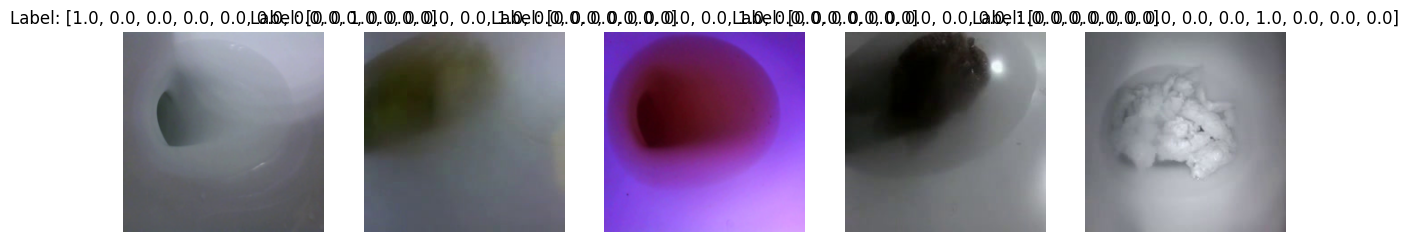

In [12]:
import matplotlib.pyplot as plt

# Function to show sample images and labels
def show_sample_images(data_loader, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    # Get a batch of data
    for batch in data_loader:
        images, labels = batch

        for i in range(num_samples):
            ax = axes[i]
            ax.imshow(images[i].permute(1, 2, 0))
            ax.set_title(f"Label: {labels[i].tolist()}")
            ax.axis("off")

        break  # Display only the first batch

    plt.show()


# Call the function to display sample images and labels from the train DataLoader
show_sample_images(train_dataloader, num_samples=5)


In [13]:
num_batches = len(train_dataloader)
batch_size = train_dataloader.batch_size

print(f"Number of batches in train_loader: {num_batches}")
print(f"Batch size in train_loader: {batch_size}")


Number of batches in train_loader: 761
Batch size in train_loader: 32


In [14]:

# Get the first batch of data from the train_dataloader
for batch in train_dataloader:
    images, labels = batch
    break  # Exit the loop after the first batch

# Assuming the images are in NCHW format (N: batch size, C: number of channels, H: height, W: width)
batch_size, num_channels, height, width = images.size()

print(f"Batch size: {batch_size}")
print(f"Number of channels: {num_channels}")
print(f"Image height: {height}")
print(f"Image width: {width}")


Batch size: 32
Number of channels: 3
Image height: 224
Image width: 224


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
num_classes = 10
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7 * 7 * 512, 500)
        self.fc2 = nn.Linear(500, num_classes)  # Change num_classes to the number of classes in your classification task
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = self.pool(F.relu(self.conv4(X)))
        X = self.pool(F.relu(self.conv5(X)))
        X = X.view(-1, 7 * 7 * 512)
        X = self.dropout(X)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = self.fc2(X)
        return X

model = Classifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 20
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    for X_Train, Y_Train in train_dataloader:
        X_Train, Y_Train = X_Train.to(device), Y_Train.to(device)
        out = model(X_Train)

        optimizer.zero_grad()
        loss = criterion(out, Y_Train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_Train.shape[0]
    train_loss = train_loss / len(train_dataloader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


cuda
Epoch: 1 	Training Loss: 1.331817
Epoch: 2 	Training Loss: 0.950072
Epoch: 3 	Training Loss: 0.804981
Epoch: 4 	Training Loss: 0.730492
Epoch: 5 	Training Loss: 0.676285
Epoch: 6 	Training Loss: 0.656606
Epoch: 7 	Training Loss: 0.632002
Epoch: 8 	Training Loss: 0.627590
Epoch: 9 	Training Loss: 0.612727
Epoch: 10 	Training Loss: 0.604631
Epoch: 11 	Training Loss: 0.591810
Epoch: 12 	Training Loss: 0.585630
Epoch: 13 	Training Loss: 0.586698
Epoch: 14 	Training Loss: 0.574143
Epoch: 15 	Training Loss: 0.574283
Epoch: 16 	Training Loss: 0.570166
Epoch: 17 	Training Loss: 0.563770
Epoch: 18 	Training Loss: 0.560968
Epoch: 19 	Training Loss: 0.564474
Epoch: 20 	Training Loss: 0.558790


In [ ]:
batch_size = 32
test_loss = 0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
model.eval()
for X_Test, Y_Test in val_dataloader:
    X_Test, Y_Test = X_Test.to(device), Y_Test.to(device)
    out = model(X_Test)
    test_loss += criterion(out, Y_Test).item() * X_Test.shape[0]
    top_p, top_class = torch.max(out, dim = 1)
    correct_tensor = top_class.eq(Y_Test.data.view_as(top_class))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(Y_Test.size(0)):
        label = Y_Test.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(val_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            flower_classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))